In [1]:
import os
os.chdir('../')

In [16]:
import torch 
from torch import nn
import numpy as np

from cids.anomaly_scores import ReconstructionAnomaly
from cids.util.metrics import f1_score
from cids.util import misc_funcs as misc
from cids.data import OpTCDataset
from cids.models.nn import MLP, Autoencoder

In [8]:
model_path_base = os.path.join(misc.root(), "models/03_semisupervision/unsupervised/OpTC/MLPAE/201/MLPAE-SSL-INV-1-0/ckpt.pt")
model_path_ssl = os.path.join(misc.root(), "models/03_semisupervision/finetuning/cids-v5_201_eval-ff_train--104-170-205-255-321-355-419-462/MLPAE/MLPAE-SSL-INV-1/MLPAE-SSL-INV-1-0/029.pt")
data_path = "cids-v5_201_eval-ff_eval--503-559-609--cids-v5_201_eval-ff_train--benign_only"
device = "cuda:0"

In [17]:
data = OpTCDataset(
    data_path,
    parts=4,
    eval_mode=True,
    only_benign=False,
    stage=5
)
dl = torch.utils.data.DataLoader(data, batch_size=32)

encoder = MLP(input_dim=1690, hidden_dims=[256], output_dim=20)
decoder = MLP(input_dim=20, hidden_dims=[256], output_dim=1690)
decoder = nn.Sequential(decoder, nn.Sigmoid())

model_base = Autoencoder(encoder=encoder, decoder=decoder)


ckpt = torch.load(model_path_base, weights_only=True)
model_base.load_state_dict(ckpt["model_state_dict"])
del ckpt
model_base.to(device=device)

encoder = MLP(input_dim=1690, hidden_dims=[256], output_dim=20)
decoder = MLP(input_dim=20, hidden_dims=[256], output_dim=1690)
decoder = nn.Sequential(decoder, nn.Sigmoid())

model_ssl = Autoencoder(encoder=encoder, decoder=decoder)


ckpt = torch.load(model_path_ssl, weights_only=True)
model_ssl.load_state_dict(ckpt["model_state_dict"])
del ckpt
model_ssl.to(device=device)

Autoencoder(
  (encoder): MLP(
    (input_layer): Linear(in_features=1690, out_features=256, bias=True)
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=256, out_features=20, bias=True)
    (dropout): Identity()
  )
  (decoder): Sequential(
    (0): MLP(
      (input_layer): Linear(in_features=20, out_features=256, bias=True)
      (hidden_layers): ModuleList()
      (output_layer): Linear(in_features=256, out_features=1690, bias=True)
      (dropout): Identity()
    )
    (1): Sigmoid()
  )
)

In [18]:
anomaly = ReconstructionAnomaly(model=model_base, device=device)
anomaly_ssl = ReconstructionAnomaly(model=model_ssl, device=device)

In [ ]:
benign_scores = {"base": [], "ssl": []}
malicious_scores = {"base": [], "ssl": []}
for inp, lbl in dl:
    inp = torch.flatten(inp, start_dim=1).to(device=device)
    lbl = lbl.to(device=device)

    with torch.no_grad():
        scores = anomaly.get_scores(inp)
        benign_scores["base"].append(scores[lbl == 0].cpu().numpy())
        malicious_scores["base"].append(scores[lbl == 1].cpu().numpy())

        scores = anomaly_ssl.get_scores(inp)
        benign_scores["ssl"].append(scores[lbl == 0].cpu().numpy())
        malicious_scores["ssl"].append(scores[lbl == 1].cpu().numpy())

for key in benign_scores:
    benign_scores[key] = np.concatenate(benign_scores[key])
    malicious_scores[key] = np.concatenate(malicious_scores[key])

In [28]:
benign_scores["base5"] = 5 * benign_scores["base"]
malicious_scores["base5"] = 5 * malicious_scores["base"]

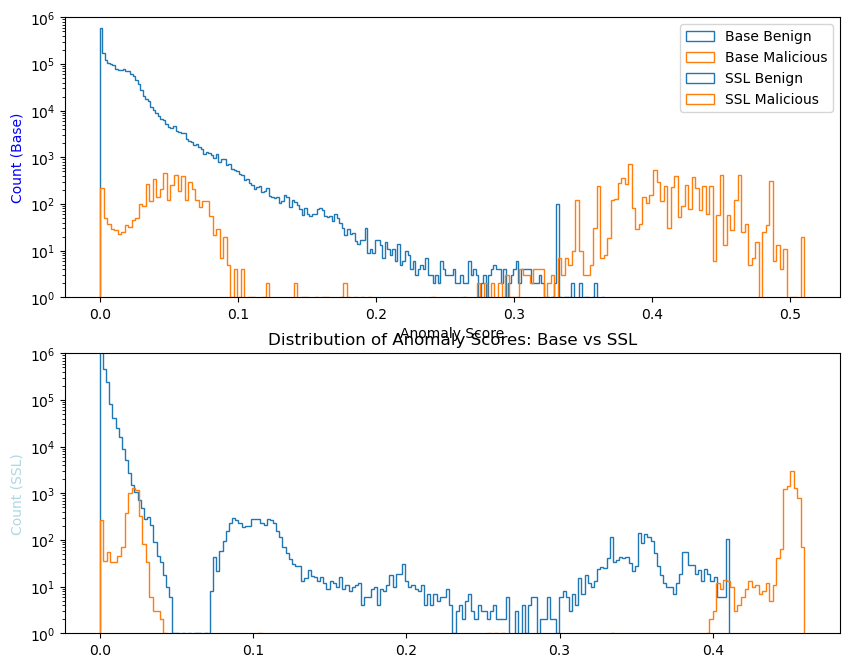

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
ax1, ax2 = axs
# Plot base scores
n1, bins1, patches1 = ax1.hist(benign_scores['base5'], bins=200, histtype='step', log=True, label='Base Benign')
n2, bins2, patches2 = ax1.hist(malicious_scores['base5'], bins=200, histtype='step', log=True, label='Base Malicious')

# Plot SSL scores on the second y-axis
n3, bins3, patches3 = ax2.hist(benign_scores['ssl'], bins=200, histtype='step', log=True, label='SSL Benign')
n4, bins4, patches4 = ax2.hist(malicious_scores['ssl'], bins=200, histtype='step', log=True, label='SSL Malicious')

ax1.set_xlabel('Anomaly Score')
ax1.set_ylabel('Count (Base)', color='blue')
ax2.set_ylabel('Count (SSL)', color='lightblue')

# Set y-axis limits to put second axis below first
ax1.set_ylim(1, 1e6)
ax2.set_ylim(1, 1e6)

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Distribution of Anomaly Scores: Base vs SSL')
plt.show()